### Clone the dataset repository

In [2]:
!git clone https://github.com/emanhamed/Houses-dataset

Cloning into 'Houses-dataset'...
remote: Enumerating objects: 2161, done.
remote: Total 2161 (delta 0), reused 0 (delta 0), pack-reused 2161
Receiving objects: 100% (2161/2161), 176.26 MiB | 25.32 MiB/s, done.
Resolving deltas: 100% (18/18), done.


### Import the dependencies

In [2]:
import datasets
import models
from sklearn.model_selection import train_test_split
from keras.layers.core import Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import concatenate
import numpy as np
import argparse
import locale
import os

Using TensorFlow backend.


### Load and split the dataset

In [0]:
df = datasets.load_attributes("Houses-dataset/Houses Dataset/HousesInfo.txt")
images = datasets.load_images(df, "Houses-dataset/Houses Dataset")

images = images/255.0

(trainAttrX, testAttrX, trainImagesX, testImagesX) = train_test_split(df, images,
                                                     test_size=0.25, random_state=42)

### Preprocess the data

In [71]:
max_price = trainAttrX["price"].max()
trainY = trainAttrX["price"] / max_price
testY = testAttrX["price"] / max_price

(trainAttrX, testAttrX) = datasets.process_attributes(df, trainAttrX, testAttrX)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


### Build the model

In [0]:
mlp = models.build_mlp(trainAttrX.shape[1], False)
cnn = models.build_cnn(64, 64, 3, regress=False)

concatenated = concatenate([mlp.output, cnn.output])

x = Dense(4, activation="relu")(concatenated)
x = Dense(1, activation="linear")(x)

model = Model(inputs=[mlp.input, cnn.input], outputs=x)

### Choose the optimizer and compile the model

In [73]:
optimizer = Adam(lr=1e-3, decay=1e-3/200)
model.compile(loss="mean_absolute_percentage_error", optimizer=optimizer)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 64, 64, 16)   448         input_2[0][0]                    
__________________________________________________________________________________________________
activation_6 (Activation)       (None, 64, 64, 16)   0           conv2d_4[0][0]                   
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 64, 64, 16)   64          activation_6[0][0]               
__________________________________________________________________________________________________
max_poolin

### Train the model

In [74]:
model.fit(
	[trainAttrX, trainImagesX], trainY,
	validation_data=([testAttrX, testImagesX], testY),
	epochs=200, batch_size=8)

Train on 288 samples, validate on 96 samples
Epoch 1/200
288/288 [==============================] - 2s 6ms/step - loss: 809.8560 - val_loss: 1848.5160
Epoch 2/200
288/288 [==============================] - 1s 2ms/step - loss: 388.9920 - val_loss: 923.8841
Epoch 3/200
288/288 [==============================] - 1s 2ms/step - loss: 228.4588 - val_loss: 101.0096
Epoch 4/200
288/288 [==============================] - 1s 2ms/step - loss: 178.9404 - val_loss: 81.2412
Epoch 5/200
288/288 [==============================] - 1s 2ms/step - loss: 128.7170 - val_loss: 73.8090
Epoch 6/200
288/288 [==============================] - 1s 2ms/step - loss: 110.9636 - val_loss: 65.0066
Epoch 7/200
288/288 [==============================] - 1s 2ms/step - loss: 77.2173 - val_loss: 64.2034
Epoch 8/200
288/288 [==============================] - 1s 2ms/step - loss: 81.8582 - val_loss: 54.8672
Epoch 9/200
288/288 [==============================] - 1s 2ms/step - loss: 80.9631 - val_loss: 52.4268
Epoch 10/200
288/2

### Make predictions

In [0]:
predictions = model.predict([testAttrX, testImagesX])

difference = predictions.flatten() - testY
percent_difference = (difference/testY)*100
abs_percent_difference = np.abs(percent_difference)

### Calculate mean and std

In [76]:
mean = np.mean(abs_percent_difference)
std = np.std(abs_percent_difference)

locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print("Avg. house price: {}, std house price: {}".format(
	locale.currency(df["price"].mean(), grouping=True),
	locale.currency(df["price"].std(), grouping=True)))
print("Mean: {:.2f}%, std: {:.2f}%".format(mean, std))

Avg. house price: $527,956.12, std house price: $479,979.80
Mean: 25.18%, std: 30.37%


### Test on a random image

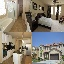

In [88]:
from IPython.display import Image

q = model.predict([[testAttrX[42]], [testImagesX[42]]])[0][0]

cv2.imwrite("img.jpg", testImagesX[42]*255)
Image(filename='img.jpg', width=150, height=150) 

In [87]:
print("Actual Price: {:.2f}".format(testY.iloc[42]*max_price))
print("Predicted Price: {:.2f}".format(q*max_price))

Actual Price: 560000.00
Predicted Price: 577228.69
